# [OpenCV-Python Tutorial] Classification

---

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os, sys
import tarfile
import time
import random
import cPickle as pickle

In [295]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 200

vocabPath = os.path.join(caltech_dir, 'vocab.pkl')
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

## Download Caltech-101 dataset

In [3]:
def download_file(url, path):
    import urllib2
    file_name = url.split('/')[-1]
    u = urllib2.urlopen(url)
    f = open(os.path.join(path, file_name), 'wb')
    meta = u.info()
    file_size = int(meta.getheaders("Content-Length")[0])
    print "Downloading: %s Bytes: %s" % (file_name, file_size)

    download_size = 0
    block_size = 8192
    while True:
        buf = u.read(block_size)
        if not buf:
            break
        download_size += len(buf)
        f.write(buf)
        status = "\r%12d  [%3.2f%%]" % (download_size, download_size * 100. / file_size)
        print status,
        sys.stdout.flush()
    f.close()

if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print 'Downloading Caltech-101'
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        download_file(caltech_url, '.')
    print 'Extracting Caltech-101'
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print 'Caltech-101 dataset checked'

Caltech-101 dataset checked


## Setup Data

Select 15 train/test images for each class
done


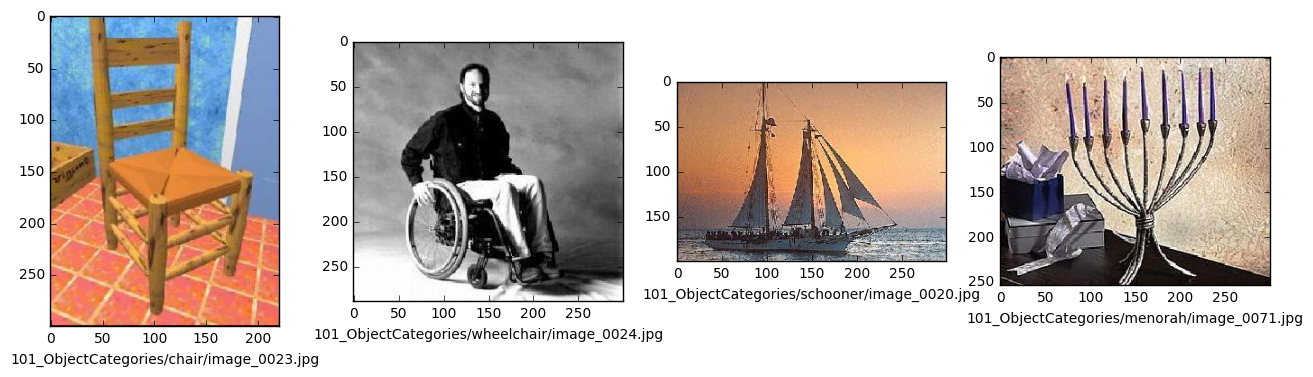

In [421]:
# Setup Data
# Select 15 train/test images for each class
print 'Select 15 train/test images for each class'
classes = os.walk(caltech_dir).next()[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c)
    ims = [f for f in os.walk(class_dir).next()[2] if f.endswith('.jpg')]
    random.shuffle(ims)
    train_image_ll.append([os.path.join(caltech_dir,c,f) for f in ims[:numTrain]])
    test_image_ll.append([os.path.join(caltech_dir,c,f) for f in ims[numTrain:numTrain+numTest]])
print 'done'

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## Train Vocabulary

In [423]:
# Train vocabulary
if not os.path.exists(vocabPath) or True:
    # Get SIFT features from 60 random training image to build a dictionary
    print "Extracting SIFT features some training images..."
    SIFT_descrs = []
    sift = cv2.xfeatures2d.SIFT_create()
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 60)
    for fpath in temp:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)
        SIFT_descrs.append(des)
    SIFT_descrs = np.concatenate(SIFT_descrs, axis=0)
    
    # Quantize the descriptors to get the visual words
    print "Running K-means clustering (%d -> %d)..." % (SIFT_descrs.shape[0], numWords)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(SIFT_descrs_temp, numWords, None, criteria, attempts, flags)
    print('Elapsed time: %.6fs' % (time.time() - start_time))
    
    print 'Saving...' 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print "Load the trained visual words..."
    with open(vocabPath) as fd:
        vocab = pickle.load(fd)

print 'Done!'

Extracting SIFT features some training images...
Running K-means clustering (26801 -> 200)...
Elapsed time: 98.806202s
Saving...
Done!


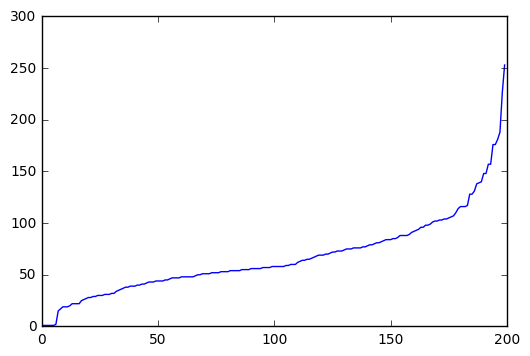

In [424]:
import collections
myCounter = collections.Counter(bestLabels.flatten())
plt.plot(sorted(myCounter.values()))

## Genarate BoW for Training Images

In [425]:
# Extract SIFT for all training images
print 'Extract SIFT for all training images'
SIFT_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print c, 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)
        temp.append(des)
    SIFT_train_ll.append(temp)
print 'done!'

Extract SIFT for all training images
accordion airplanes anchor ant BACKGROUND_Google barrel bass beaver binocular bonsai brain brontosaurus buddha butterfly camera cannon car_side ceiling_fan cellphone chair chandelier cougar_body cougar_face crab crayfish crocodile crocodile_head cup dalmatian dollar_bill dolphin dragonfly electric_guitar elephant emu euphonium ewer Faces Faces_easy ferry flamingo flamingo_head garfield gerenuk gramophone grand_piano hawksbill headphone hedgehog helicopter ibis inline_skate joshua_tree kangaroo ketch lamp laptop Leopards llama lobster lotus mandolin mayfly menorah metronome minaret Motorbikes nautilus octopus okapi pagoda panda pigeon pizza platypus pyramid revolver rhino rooster saxophone schooner scissors scorpion sea_horse snoopy soccer_ball stapler starfish stegosaurus stop_sign strawberry sunflower tick trilobite umbrella watch water_lilly wheelchair wild_cat windsor_chair wrench yin_yang


In [514]:
# Compute histogram for training images
print 'Compute histogram for training images'
BoW_train_ll = []
bf = cv2.BFMatcher()
for c, SIFT_list in zip(classes, SIFT_train_ll):
    print c,
    temp = []
    for des in SIFT_list:
        matches = bf.knnMatch(des, vocab, k=1)
        hist = np.zeros(numWords, dtype=np.float32)
        for m in matches:
            hist[m[0].trainIdx] += 1
#         hist /= np.sum(hist)
        hist -= np.average(hist)
        hist /= np.std(hist)
        temp.append(hist)
    BoW_train_ll.append(temp)

Compute histogram for training images
accordion airplanes anchor ant BACKGROUND_Google barrel bass beaver binocular bonsai brain brontosaurus buddha butterfly camera cannon car_side ceiling_fan cellphone chair chandelier cougar_body cougar_face crab crayfish crocodile crocodile_head cup dalmatian dollar_bill dolphin dragonfly electric_guitar elephant emu euphonium ewer Faces Faces_easy ferry flamingo flamingo_head garfield gerenuk gramophone grand_piano hawksbill headphone hedgehog helicopter ibis inline_skate joshua_tree kangaroo ketch lamp laptop Leopards llama lobster lotus mandolin mayfly menorah metronome minaret Motorbikes nautilus octopus okapi pagoda panda pigeon pizza platypus pyramid revolver rhino rooster saxophone schooner scissors scorpion sea_horse snoopy soccer_ball stapler starfish stegosaurus stop_sign strawberry sunflower tick trilobite umbrella watch water_lilly wheelchair wild_cat windsor_chair wrench yin_yang


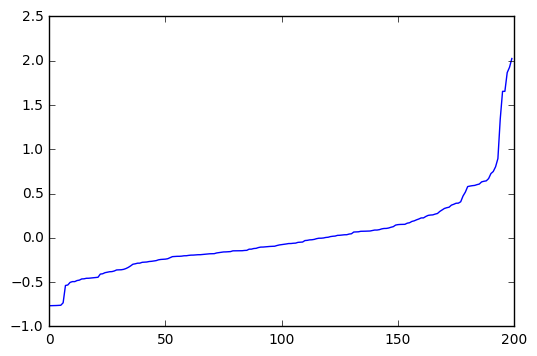

In [516]:
word_ratio = np.average([np.average(temp, axis=0) for temp in BoW_train_ll], axis=0)
plt.plot(sorted(word_ratio))

## Train SVM

In [517]:
# Setting training data(BoW, label) for SVM
print 'Setting training data(BoW, label) for SVM'
train_bow = []
train_labels = []
for i, BoW_list in enumerate(BoW_train_ll):
    train_bow.append(np.concatenate(BoW_list).reshape([numTrain,numWords]))
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 200), train_labels: (1530,1)

print train_bow.shape
print train_labels.shape

SVM_train_data = cv2.ml.TrainData_create(train_bow, cv2.ml.ROW_SAMPLE, train_labels)

Setting training data(BoW, label) for SVM
(1530, 200)
(1530, 1)


In [533]:
# Train SVM
print 'Training SVM...'
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.001)
# svm.setGamma(0.001)
svm.setTermCriteria((cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0))
# svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 0.001))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: %.6fs' % (time.time() - start_time))

print 'Saving SVM...'
svm.save(svmPath)
print 'Done!'

Training SVM...
Elapsed time: 0.546028s
Saving SVM...
Done!


In [534]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.568627


In [480]:
svm.isTrained()

True

## Test trained SVM with test images

In [515]:
# Extract SIFT for all test images
print 'Extract SIFT for all test images'
SIFT_test_ll = []
BoW_test_ll = []

bf = cv2.BFMatcher()
for c, image_list in zip(classes, test_image_ll):
    print c, 
    temp1 = []
    temp2 = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)
        temp1.append(des)
        
        matches = bf.knnMatch(des, vocab, k=1)
        hist = np.zeros(numWords, dtype=np.float32)
        for m in matches:
            hist[m[0].trainIdx] += 1
#         hist /= np.sum(hist)
        hist -= np.average(hist)
        hist /= np.std(hist)
        temp2.append(hist)
    SIFT_test_ll.append(temp1)
    BoW_test_ll.append(temp2)

Extract SIFT for all test images
accordion airplanes anchor ant BACKGROUND_Google barrel bass beaver binocular bonsai brain brontosaurus buddha butterfly camera cannon car_side ceiling_fan cellphone chair chandelier cougar_body cougar_face crab crayfish crocodile crocodile_head cup dalmatian dollar_bill dolphin dragonfly electric_guitar elephant emu euphonium ewer Faces Faces_easy ferry flamingo flamingo_head garfield gerenuk gramophone grand_piano hawksbill headphone hedgehog helicopter ibis inline_skate joshua_tree kangaroo ketch lamp laptop Leopards llama lobster lotus mandolin mayfly menorah metronome minaret Motorbikes nautilus octopus okapi pagoda panda pigeon pizza platypus pyramid revolver rhino rooster saxophone schooner scissors scorpion sea_horse snoopy soccer_ball stapler starfish stegosaurus stop_sign strawberry sunflower tick trilobite umbrella watch water_lilly wheelchair wild_cat windsor_chair wrench yin_yang


In [535]:
# Setting test data(BoW, label) for SVM
print 'Setting test data(BoW, label) for SVM'
test_bow = []
test_labels = []
for i, BoW_list in enumerate(BoW_test_ll):
    test_bow.append(np.concatenate(BoW_list).reshape([numTest,numWords]))
    test_labels.extend([i] * len(BoW_list))
test_bow = np.concatenate(test_bow, axis=0)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses,1))
# => train_bow: (1530, 200), train_labels: (1530,1)

print test_bow.shape
print test_labels.shape

Setting test data(BoW, label) for SVM
(1530, 200)
(1530, 1)


In [536]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: %.6f' % np.average(test_preds == test_labels))

Test Accuracy: 0.169935
